# SPOT

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
import sys
sys.path.append("../")

from meltria import loader

In [4]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

from meltria.priorknowledge.priorknowledge import SockShopKnowledge

sockshop_pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [5]:
metrics_files = !find "/datasets/argowf-chaos-{SOCKSHOP_DATASET_ID}/" -type f -name "*.json"
records = loader.load_dataset(metrics_files, target_metric_types={
        "containers": True,
        "services": True,
        "nodes": True,
        "middlewares": True,
    },
    num_datapoints=4*45, # 45min
)

In [6]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    use_manually_selected_metrics=False,
)

In [24]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-memory-hog", "carts")][1]
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    # data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape

(180, 185)

In [25]:
import numpy as np
from ads_evt import biSPOT

DEFAULT_PROBA = 1e-4
DEFAULT_N_POINTS = 10


def spot(
    train_y: np.ndarray, test_y: np.ndarray, proba: float = DEFAULT_PROBA, n_points: int = DEFAULT_N_POINTS
) -> tuple[np.ndarray, np.ndarray]:
    model = biSPOT(q=proba, n_points=n_points)
    model.fit(init_data=train_y, data=test_y)
    model.initialize()
    results = model.run(with_alarm=True)
    scores: list[float] = []
    for index, (upper, lower) in enumerate(zip(results["upper_thresholds"], results["lower_thresholds"])):
        width: float = upper - lower
        if width <= 0:
            width = 1
        if test_y[index] > upper:
            scores.append((test_y[index] - upper) / width)
        elif test_y[index] < lower:
            scores.append((lower - test_y[index]) / width)
        else:
            scores.append(0)

    return np.array(scores), np.array(results["alarms"])


def detect_anomalies_with_spot(
    x: np.ndarray, anomalous_start_idx: int, proba: float = DEFAULT_PROBA, n_points: int = DEFAULT_N_POINTS
) -> tuple[bool, float]:
    test_start_idx = x.shape[0] - (anomalous_start_idx + 1)
    train, test = x[:test_start_idx], x[test_start_idx:]
    scores, alarms = spot(train, test, proba=proba, n_points=n_points)
    return alarms.size > 0, np.max(scores)


In [48]:
# iterate dataset and detect anomalies
from tqdm import tqdm
from joblib import Parallel, delayed

def _detect(x, label, anomalous_start_idx):
    is_anomaly, score = detect_anomalies_with_spot(x, anomalous_start_idx=anomalous_start_idx, proba=1e-4, n_points=10)
    return (label, is_anomaly, x)

results: list[tuple[str, bool, np.ndarray]] = Parallel(n_jobs=-1)(
    delayed(_detect)(content.values, label, anomalous_start_idx=159)
    for label, content in dataset.items()
)

In [52]:
results_df = pd.DataFrame(results, columns=["metric", "is_anomaly", "values"])
# display the ratio of normal and abnormal data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df.groupby("is_anomaly").count())
    display(results_df.sample(n=min(200, results_df.shape[0])).sort_values("is_anomaly"))

metric  values
is_anomaly                
False          104     104
True            81      81

metric  is_anomaly  \
77                      c-orders_memory_usage_bytes       False   
112                             c-orders-db_threads       False   
60      c-catalogue-db_network_transmit_bytes_total       False   
130              c-user-db_memory_working_set_bytes       False   
141                       c-user-db_fs_writes_total       False   
162           c-user_network_transmit_packets_total       False   
56          c-catalogue-db_cpu_system_seconds_total       False   
52          c-catalogue-db_memory_working_set_bytes       False   
103               c-shipping_cpu_user_seconds_total       False   
23           c-carts-db_network_receive_bytes_total       False   
66             c-front-end_memory_working_set_bytes       False   
79                c-orders_memory_working_set_bytes       False   
100                c-shipping_cpu_cfs_periods_total       False   
13             c-carts_network_transmit_bytes_total       False   
138              c-user-db_blkio_device_usage_total       False   
5               c-carts_network_receive_bytes_total       False   
149         c-payment_network_receive_packets_total       False   
133         c-user-db_network_receive_packets_total       False   
175                              s-front-end_errors       False   
118     c-orders-db_cpu_cfs_throttled_periods_total       False   
116      c-orders-db_network_transmit_packets_total       False   
65                            c-front-end_last_seen       False   
54     c-catalogue-db_network_receive_packets_total       False   
110                           c-orders-db_last_seen       False   
163                 c-user_cpu_system_seconds_total       False   
82           c-orders_network_receive_packets_total       False   
153                 c-payment_cpu_cfs_periods_total       False   
88            c-orders_network_transmit_bytes_total       False   
102         c-shipping_network_transmit_bytes_total       False   
62                        c-catalogue-db_memory_rss       False   
93              c-shipping_memory_working_set_bytes       False   
161            c-user_network_receive_packets_total       False   
114       c-orders-db_network_receive_packets_total       False   
76                           c-front-end_memory_rss       False   
146       c-payment_cpu_cfs_throttled_seconds_total       False   
131                               c-user-db_threads       False   
35                            c-carts-db_memory_rss       False   
154               c-payment_cpu_usage_seconds_total       False   
167             c-user_network_transmit_bytes_total       False   
129                             c-user-db_last_seen       False   
166                  c-user_cpu_usage_seconds_total       False   
99       c-shipping_cpu_cfs_throttled_periods_total       False   
107                      c-orders-db_fs_reads_total       False   
134                 c-user-db_fs_writes_bytes_total       False   
165                    c-user_cpu_cfs_periods_total       False   
7             c-carts_network_receive_packets_total       False   
32                       c-carts-db_fs_writes_total       False   
126                    c-user-db_memory_usage_bytes       False   
139                 c-user-db_cpu_cfs_periods_total       False   
17                  c-carts-db_fs_reads_bytes_total       False   
69       c-front-end_network_transmit_packets_total       False   
63                   c-front-end_memory_usage_bytes       False   
51                         c-catalogue-db_last_seen       False   
97        c-shipping_network_transmit_packets_total       False   
91                    c-shipping_memory_usage_bytes       False   
95           c-shipping_network_receive_bytes_total       False   
55    c-catalogue-db_network_transmit_packets_total       False   
49                c-catalogue-db_memory_usage_bytes       False   
132           c-user-db_network_receive_bytes_total       False   
22                       

In [53]:
from eval.groundtruth import check_cause_metrics
from eval.tsdr import recall_of_cause_metrics

def calc_recall(results_df, record, optional_cause=False):
    anomalous_metrics = results_df.query("is_anomaly == True")["metric"].values.tolist()
    _, found_cause_metrics = check_cause_metrics(record.pk, anomalous_metrics, record.chaos_type(), record.chaos_comp(), optional_cause=optional_cause)
    _, total_cause_metrics = check_cause_metrics(record.pk, dataset.columns.tolist(), record.chaos_type(), record.chaos_comp(), optional_cause=optional_cause)
    diff_cause_metrics = set(total_cause_metrics) - set(found_cause_metrics)
    return recall_of_cause_metrics(set(total_cause_metrics), set(found_cause_metrics.tolist())), diff_cause_metrics

print(calc_recall(results_df, record, optional_cause=False))
recall, diff = calc_recall(results_df, record, optional_cause=True)
if len(diff) > 0:
    dataset[list(diff)].plot(subplots=True)

(1.0, set())


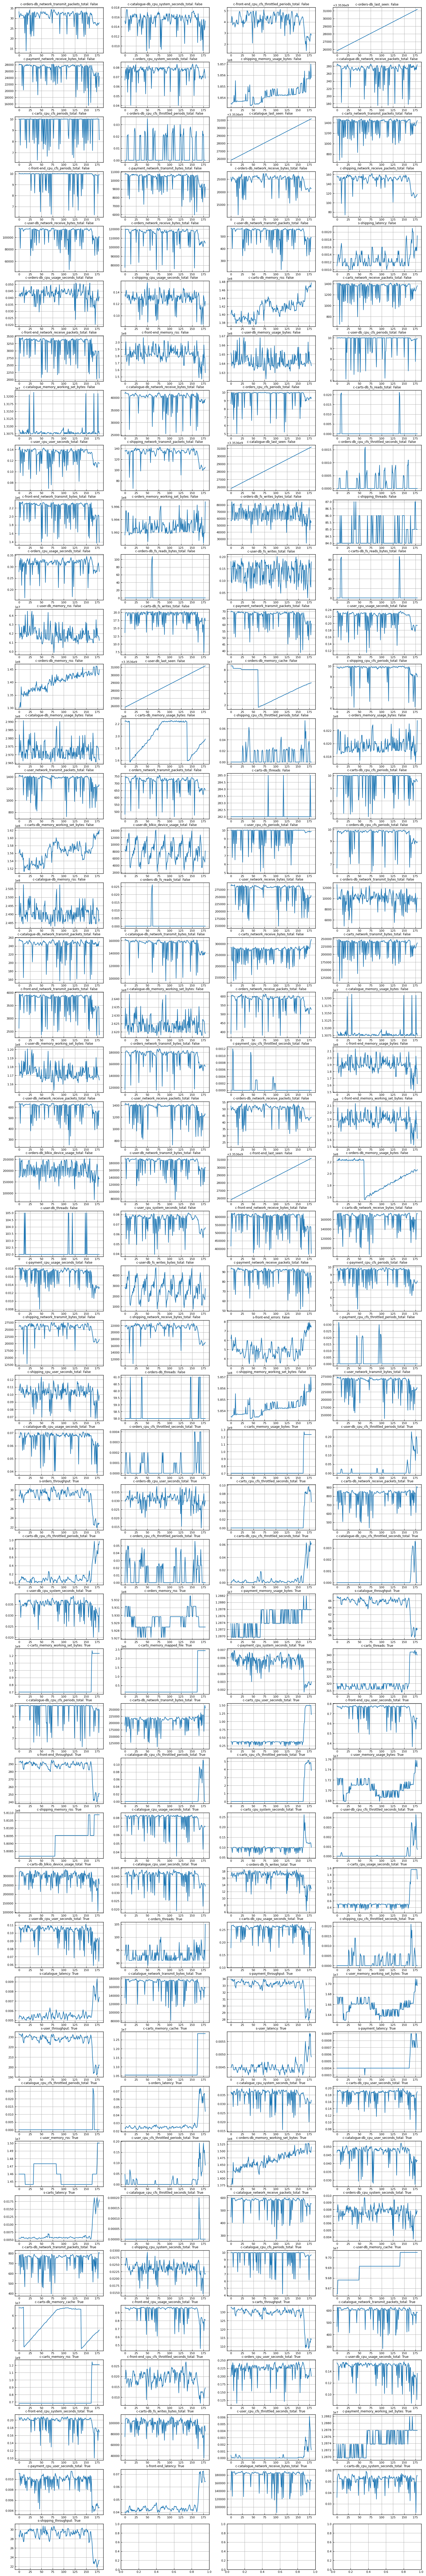

In [51]:
import math

_results_df = results_df.sample(n=min(200, results_df.shape[0]))
ncols = 4
nrows = math.ceil(_results_df.shape[0] / ncols)
fig, axs = plt.subplots(figsize=(20, 2.7 * nrows), nrows=nrows, ncols=ncols)
for (index, data), ax in zip(_results_df.sort_values("is_anomaly").iterrows(), axs.flatten()):  # type: ignore
    ax.plot(data["values"])
    ax.set_title(f"{data['metric']}: {data['is_anomaly']}")